In [1]:
! pip install simpy

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import simpy
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import matplotlib.pyplot as plt

In [3]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

# 设置输出格式，以显示所有行和列
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 初始化模拟环境和顾客到达过程
def setup(env, num_servers, servicetime, Lambda, waiting_times):
    # 生成服务器资源
    server = simpy.Resource(env, num_servers)

    def service(customer):
        """服务过程使用指数分布的服务时间"""
        yield env.timeout(np.random.exponential(servicetime))

    def customer(name):
        """顾客到达和服务过程"""
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            # 记录每个顾客的等待时间
            waiting_times.append(waiting_time)
    
    # 生成初始顾客
    env.process(customer('Customer 0'))

    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

# 运行模拟函数
def run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # 到达率
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings



In [4]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          1.080654   
1             2  0.10          0.975977   
2             4  0.10          1.005816   
3             1  0.50          1.998980   
4             2  0.50          1.315733   
5             4  0.50          1.060937   
6             1  0.90          4.934402   
7             2  0.90          3.711317   
8             4  0.90          2.249165   
9             1  0.99          6.844037   
10            2  0.99          4.431230   
11            4  0.99          3.696195   

                                     all_waiting_time  \
0   [[0.17740539865014757, 0.3295320430234545, 0.9...   
1   [[0.861631609184445, 0.13912948990167617, 0.35...   
2   [[2.3038503883601607, 1.7042792639332403, 0.80...   
3   [[0.28602306328749544, 0.45464764371256355, 0....   
4   [[0.0765074660071361, 0.47124748737986966, 1.5...   
5   [[0.2655669071750033, 0.48301075448915776, 0.0...   
6   [[0.8002231060449676, 0.7105017383353

In [5]:
def run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

def prepare_plot_data(simulation_results, server_configs):
    plot_data = {'rho': [], 'avg_waiting_time': [], 'num_servers': []}
    
    for num_servers, all_waiting_times in zip(server_configs, simulation_results):
        for rho, waiting_times in all_waiting_times.items():
            plot_data['rho'].extend([rho] * len(waiting_times))
            plot_data['avg_waiting_time'].extend(waiting_times)
            plot_data['num_servers'].extend([str(num_servers)] * len(waiting_times))
    
    return pd.DataFrame(plot_data)

def plot_data(df):
    sns.lineplot(data=df, x='rho', y='avg_waiting_time', hue='num_servers')
    plt.title('Comparison of Average Waiting Time by System Load')
    plt.xlabel('System Load (rho)')
    plt.ylabel('Average Waiting Time')
    plt.legend(title='Number of Servers')
    plt.show()


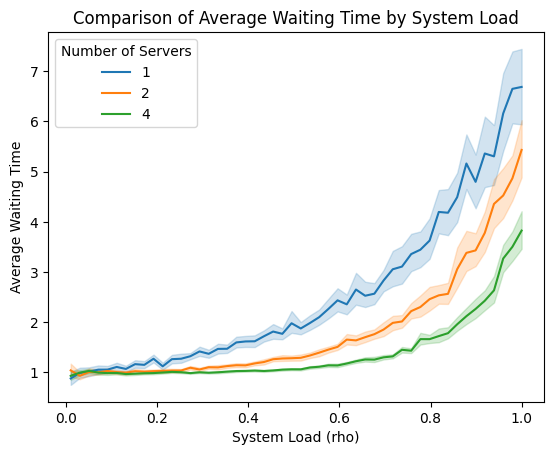

In [8]:
# 定义参数
SIM_TIME = 100
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 50)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


In [9]:
print(all_sim_data[0]['all_waiting_time'][1])

[0.6692792128196248, 0.10449676951007447, 0.4554013481097172, 0.31462764436598434, 3.068114137322212, 2.2518531910125716, 2.1240614289149704, 0.9080987114871135, 2.306594911130162]


In [10]:
# 绘制直方图或密度图
def plt_distribution(all_sim_data, title, xlabel = 'Waiting Time'):
#     print(len(all_sim_data))
#     sns.histplot(all_sim_data, kde=True, element='step', stat='density', bins=200)
    sns.histplot(all_sim_data, kde=True, stat='density', bins=200)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.show()
    
# # 旧的绘制叠加的直方图或密度图
# def plt_distribution_group(sim_data_group, title, labels, xlabel = 'Waiting Time'):
# #     print(len(all_sim_data))
#     for group_data in sim_data_group:
#         sns.histplot(group_data, kde=True, stat='density', bins=200)
# #         sns.histplot(group_data, kde=True, element='step', stat='density', bins=200)

#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel('Density')
#     plt.legend(labels=labels)
#     plt.show()
    
# # 绘制叠加的直方图或密度图
# def plot_distribution_group(sim_data_group, title, labels, xlabel='Waiting Time'):
#     for group_data, label in zip(sim_data_group, labels):
#         sns.histplot(group_data, kde=True, stat='density', bins=200, label=label)

#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel('Density')
#     plt.legend()
#     plt.show()

# 绘制叠加的直方图或密度图
def plt_distribution_group(sim_data_group, title, labels, xlabel='Average Waiting Time'):
    for group_data, label in zip(sim_data_group, labels):
        sns.histplot(group_data, kde=True, stat='density', bins=200, label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def prepare_group_data(sim_data):
    # 将模拟结果中的所有等待时间整理到一个列表中
    all_waiting_times = []
    for data in sim_data:
        all_waiting_times.extend(data)

    return all_waiting_times


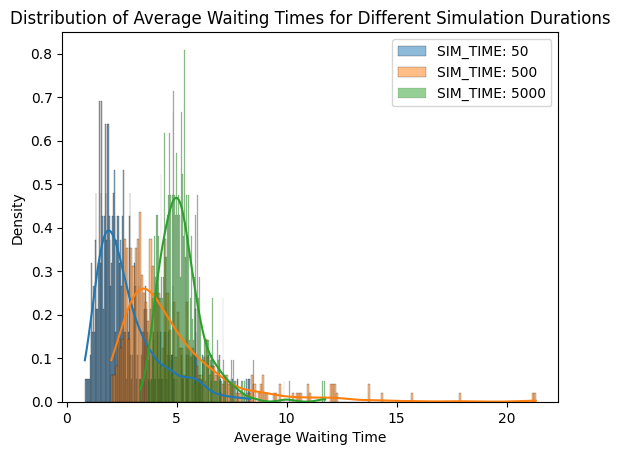

In [11]:
# 定义模拟参数
num_servers = 2  # 服务器数量
rho = 0.9  # 系统负载
MU = 1  # 服务率
SIMULATIONS = 500  # 模拟次数
SIM_TIMES = [50, 500, 5000]  # 不同的模拟时长

# 运行模拟并收集结果
simulation_results = []
for SIM_TIME in SIM_TIMES:
    _, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)
    simulation_results.append(avg_waitings)

# 定义标签
labels = [f'SIM_TIME: {SIM_TIME}' for SIM_TIME in SIM_TIMES]

# 绘制结果
plt_distribution_group(simulation_results, "Distribution of Average Waiting Times for Different Simulation Durations", labels)


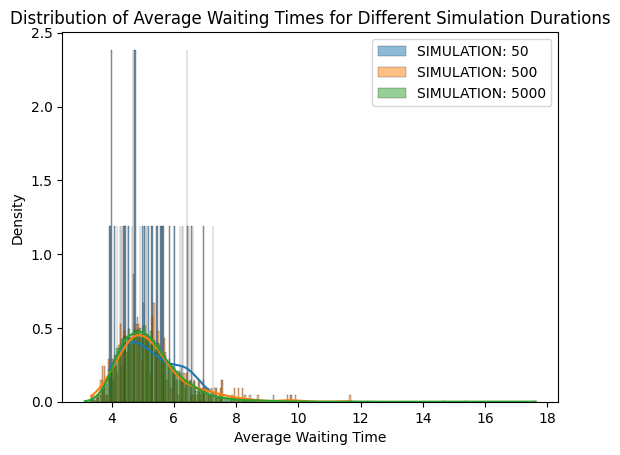

In [12]:
# 定义模拟参数
num_servers = 2  # 服务器数量
rho = 0.9  # 系统负载
MU = 1  # 服务率
SIMULATIONS = [50, 500, 5000]  # 不同的模拟时长
SIM_TIMES = 500  # 模拟时长

# 运行模拟并收集结果
simulation_results = []
for SIMULATION in SIMULATIONS:
    _, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATION)
    simulation_results.append(avg_waitings)

# 定义标签
labels = [f'SIMULATION: {SIMULATION}' for SIMULATION in SIMULATIONS]

# 绘制结果
plt_distribution_group(simulation_results, "Distribution of Average Waiting Times for Different Simulation Durations", labels)


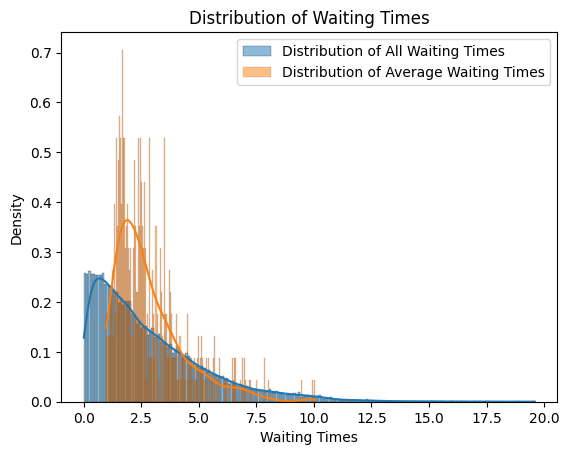

In [13]:
# Simulation parameters
num_servers = 2
rho = 0.9  # System load
MU = 1  # Service rate
SIM_TIME = 50  # Simulation duration
SIMULATIONS = 500  # Number of simulations


sim_data, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual

all_waiting_times = []
for data in sim_data:
    all_waiting_times.extend(data)

# plt_distribution(all_waiting_times, 'Distribution of All Waiting Times')
# plt_distribution(avg_waitings, 'Distribution of Average Waiting Times')
group_data = [all_waiting_times, avg_waitings]
labels = ['Distribution of All Waiting Times', 'Distribution of Average Waiting Times']
plt_distribution_group(group_data, "Distribution of Waiting Times", labels, "Waiting Times")

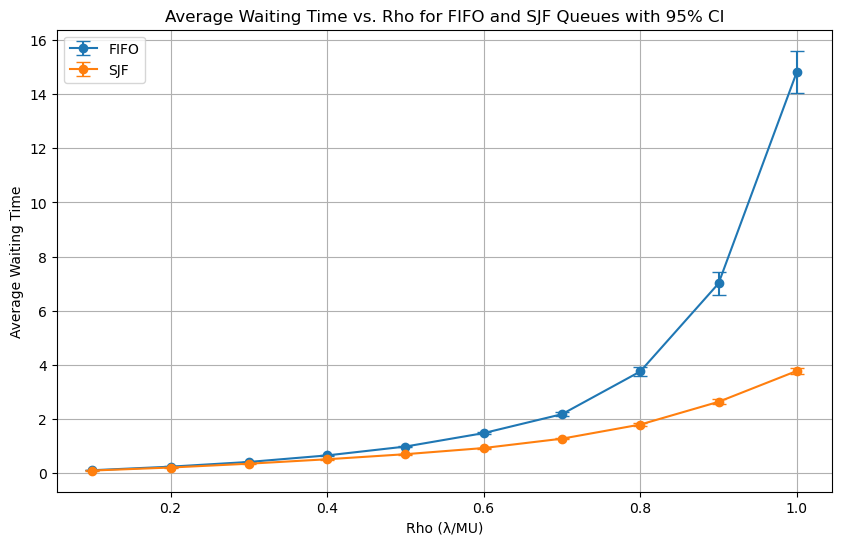

In [7]:
# Function for confidence interval calculation
def conf_int(mean, std_dev, n, p=0.95):
    z_value = st.norm.ppf((p + 1) / 2)
    margin = (z_value * std_dev) / math.sqrt(n)
    return mean - margin, mean + margin

# Adjusted job_generator to accept lambda_val
def job_generator(env, server, waiting_times, lambda_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.expovariate(MU)
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted serve to create job with service_time
def serve(env, job, server, waiting_times):
    if isinstance(server, simpy.PriorityResource): 
        request = server.request(priority=job.service_time)  # For SJF, request with job's service time as priority.
    else:
        request = server.request() # For FIFO, regular request without priority.
    
    with request as req:
        yield req # Wait for the server to be available.
        wait = env.now - job.arrive_time # Calculate waiting time.
        waiting_times.append(wait)
        yield env.timeout(job.service_time)

# Class Job with added service_time parameter
class Job:
    def __init__(self, name, arrive_time, service_time):
        self.name = name
        self.arrive_time = arrive_time
        self.service_time = service_time

# Adjusted run_simulation to accept lambda_val and pass it to job_generator
def run_simulation(server_type, lambda_val):
    env = simpy.Environment()
    waiting_times = []
    if server_type == 'SJF':
        server = simpy.PriorityResource(env, capacity=1)
    else:
        server = simpy.Resource(env, capacity=1)
    
    env.process(job_generator(env, server, waiting_times, lambda_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)  # Return the average waiting time for this simulation


# Parameters
MU = 1  # Fixed service rate
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 500  # Number of simulations for averaging

# Prepare a range of rho values
rhos = np.arange(0.1, 1.1, 0.1)
results = []

for rho in rhos:
    lambda_val = rho * MU
    for queue_type in ['FIFO', 'SJF']:
        avg_wait_times = []
        for _ in range(SIMULATIONS):
            avg_wait_time = run_simulation(queue_type, lambda_val)
            avg_wait_times.append(avg_wait_time)
        mean_wait = np.mean(avg_wait_times)
        std_dev_wait = np.std(avg_wait_times, ddof=1)
        conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
        results.append({
            'Rho': rho, 'QueueType': queue_type, 
            'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
            'ConfIntervalUpper': conf_upper
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(10, 6))
for queue_type in ['FIFO', 'SJF']:
    subset = results_df[results_df['QueueType'] == queue_type]
    plt.errorbar(subset['Rho'], subset['MeanWait'],
                 yerr=[subset['MeanWait'] - subset['ConfIntervalLower'], 
                       subset['ConfIntervalUpper'] - subset['MeanWait']],
                 label=queue_type, fmt='-o', capsize=5)
plt.xlabel('Rho (λ/MU)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs. Rho for FIFO and SJF Queues with 95% CI')
plt.legend()
plt.grid(True)
plt.show()

# After running the simulation and storing the results in `results_df`
#Print the results with 95% Confidence Intervals
# print("Simulation Results with 95% Confidence Intervals:")
# for rho in rhos:
#     print(f"\nRho (λ/MU): {rho:.2f}")
#     for queue_type in ['FIFO', 'SJF']:
#         subset = results_df[(results_df['Rho'] == rho) & (results_df['QueueType'] == queue_type)]
#         for index, row in subset.iterrows():
#             mean_wait = row['MeanWait']
#             conf_interval = (row['ConfIntervalLower'], row['ConfIntervalUpper'])
#             print(f"  Queue Type: {queue_type}, Average Waiting Time: {mean_wait:.4f}, 95% CI: {conf_interval}")


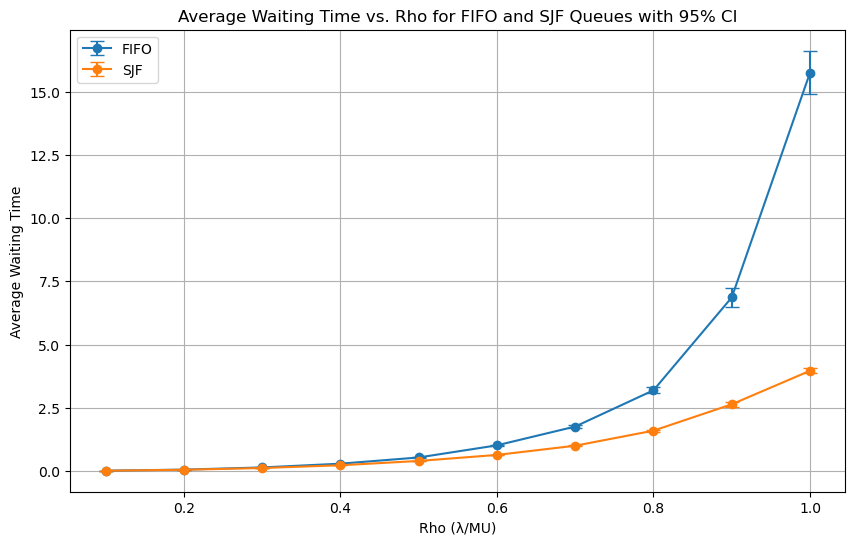

In [6]:
import simpy
import random
import numpy as np
import pandas as pd
import math
import scipy.stats as st
import matplotlib.pyplot as plt

# Function for confidence interval calculation
def conf_int(mean, std_dev, n, p=0.95):
    z_value = st.norm.ppf((p + 1) / 2)
    margin = (z_value * std_dev) / math.sqrt(n)
    return mean - margin, mean + margin

# Class Job with added service_time parameter
class Job:
    def __init__(self, name, arrive_time, service_time):
        self.name = name
        self.arrive_time = arrive_time
        self.service_time = service_time

# Adjusted serve to create job with service_time
def serve(env, job, server, waiting_times):
    if isinstance(server, simpy.PriorityResource): 
        request = server.request(priority=job.service_time)
    else:
        request = server.request()
    
    with request as req:
        yield req
        wait = env.now - job.arrive_time
        waiting_times.append(wait)
        yield env.timeout(job.service_time)

# Adjusted job_generator to accept mu_val
def job_generator(env, server, waiting_times, lambda_val, mu_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.expovariate(mu_val)
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted run_simulation to accept mu_val and pass it to job_generator
def run_simulation(server_type, lambda_val, mu_val):
    env = simpy.Environment()
    waiting_times = []
    if server_type == 'SJF':
        server = simpy.PriorityResource(env, capacity=1)
    else:
        server = simpy.Resource(env, capacity=1)
    
    env.process(job_generator(env, server, waiting_times, lambda_val, mu_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)

# Fixed parameters
LAMBDA = 0.9  # Fixed arrival rate
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 500  # Number of simulations for averaging

# Prepare a range of rho values and calculate corresponding mu values
rhos = np.arange(0.1, 1.1, 0.1)
results = []

for rho in rhos:
    mu_val = LAMBDA / rho  # Calculate mu for each rho
    for queue_type in ['FIFO', 'SJF']:
        avg_wait_times = []
        for _ in range(SIMULATIONS):
            avg_wait_time = run_simulation(queue_type, LAMBDA, mu_val)
            avg_wait_times.append(avg_wait_time)
        mean_wait = np.mean(avg_wait_times)
        std_dev_wait = np.std(avg_wait_times, ddof=1)
        conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
        results.append({
            'Rho': rho, 'QueueType': queue_type, 
            'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
            'ConfIntervalUpper': conf_upper
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(10, 6))
for queue_type in ['FIFO', 'SJF']:
    subset = results_df[results_df['QueueType'] == queue_type]
    plt.errorbar(subset['Rho'], subset['MeanWait'],
                 yerr=[subset['MeanWait'] - subset['ConfIntervalLower'], 
                       subset['ConfIntervalUpper'] - subset['MeanWait']],
                 label=queue_type, fmt='-o', capsize=5)
plt.xlabel('Rho (λ/MU)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs. Rho for FIFO and SJF Queues with 95% CI')
plt.legend()
plt.grid(True)
plt.show()

# Print the results with 95% Confidence Intervals
# print("Simulation Results with 95% Confidence Intervals:")
# for rho in rhos:
    # print(f"\nRho (λ/MU): {rho:.2f}")
    # for queue_type in ['FIFO', 'SJF']:
        # subset = results_df[(results_df['Rho'] == rho) & (results_df['QueueType'] == queue_type)]
        # for index, row in subset.iterrows():
            # mean_wait = row['MeanWait']
            # conf_interval = (row['ConfIntervalLower'], row['ConfIntervalUpper'])
            # print(f"  Queue Type: {queue_type}, Average Waiting Time: {mean_wait:.4f}, 95% CI: {conf_interval}")


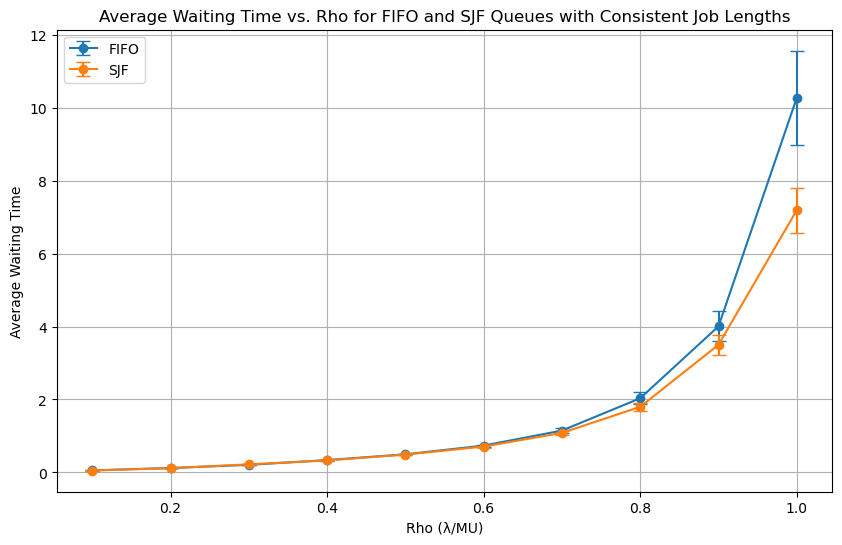

In [8]:
# Function for confidence interval calculation
def conf_int(mean, std_dev, n, p=0.95):
    z_value = st.norm.ppf((p + 1) / 2)
    margin = (z_value * std_dev) / math.sqrt(n)
    return mean - margin, mean + margin

# Class Job with added service_time parameter
class Job:
    def __init__(self, name, arrive_time, service_time):
        self.name = name
        self.arrive_time = arrive_time
        self.service_time = service_time

# Adjusted serve to create job with service_time
def serve(env, job, server, waiting_times):
    if isinstance(server, simpy.PriorityResource): 
        request = server.request(priority=job.service_time)
    else:
        request = server.request()
    
    with request as req:
        yield req
        wait = env.now - job.arrive_time
        waiting_times.append(wait)
        yield env.timeout(job.service_time)
        
# Adjusted job_generator for consistent job lengths and lambda_val
def job_generator(env, server, waiting_times, lambda_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.uniform(0.9, 1.1)  # Consistent job lengths
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted run_simulation
def run_simulation(server_type, lambda_val):
    env = simpy.Environment()
    waiting_times = []
    server = simpy.PriorityResource(env, capacity=1) if server_type == 'SJF' else simpy.Resource(env, capacity=1)
    env.process(job_generator(env, server, waiting_times, lambda_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)

# Parameters
MU = 1  # Fixed service rate (MU)
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 100  # Number of simulations for averaging
rhos = np.arange(0.1, 1.1, 0.1)  # Range of rho values

# Run the simulation
results = []
for rho in rhos:
    lambda_val = rho * MU  # Calculate lambda for each rho
    for queue_type in ['FIFO', 'SJF']:
        avg_wait_times = []
        for _ in range(SIMULATIONS):
            avg_wait_time = run_simulation(queue_type, lambda_val)
            avg_wait_times.append(avg_wait_time)
        mean_wait = np.mean(avg_wait_times)
        std_dev_wait = np.std(avg_wait_times, ddof=1)
        conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
        results.append({
            'Rho': rho, 'QueueType': queue_type, 
            'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
            'ConfIntervalUpper': conf_upper
        })

# Convert results to DataFrame and plot
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
for queue_type in ['FIFO', 'SJF']:
    subset = results_df[results_df['QueueType'] == queue_type]
    plt.errorbar(subset['Rho'], subset['MeanWait'],
                 yerr=[subset['MeanWait'] - subset['ConfIntervalLower'], 
                       subset['ConfIntervalUpper'] - subset['MeanWait']],
                 label=queue_type, fmt='-o', capsize=5)
plt.xlabel('Rho (λ/MU)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs. Rho for FIFO and SJF Queues with Consistent Job Lengths')
plt.legend()
plt.grid(True)
plt.show()


### 不用的代码

In [ ]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

# 设置输出格式，以显示所有行和列
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 定义队列类
class Queue:
    def __init__(self, env, num_servers, servicetime):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.servicetime = servicetime

    def service(self, customer):
        """服务过程使用指数分布的服务时间"""
        yield self.env.timeout(np.random.exponential(self.servicetime))

# 定义顾客到达过程
def customer(env, name, qu):
    arrival_time = env.now
    with qu.server.request() as request:
        yield request
        yield env.process(qu.service(name))
        waiting_time = env.now - arrival_time
        # 记录每个顾客的等待时间
        qu.env.waiting_times.append(waiting_time)

# 初始化模拟环境和顾客到达过程
def setup(env, num_servers, servicetime, Lambda):
    queue = Queue(env, num_servers, servicetime)
    queue.env.waiting_times = []
    # 生成初始顾客
    env.process(customer(env, 'Customer 0', queue))
    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(env, f'Customer {env.now}', queue))

# 运行模拟函数
def run_simulation(num_servers, Lambda, servicetime, SIM_TIME, SIMULATIONS):
    data_sims = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        env.process(setup(env, num_servers, servicetime, Lambda))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(env.waiting_times)
        data_sims.append(avg_waiting)
    return data_sims

# 模拟参数
MU = 1  # the capacity of each of n equal servers
SIM_TIME = 100
SIMULATIONS = 100
SERVERS = [1, 2, 4]  # 服务器数量n
RHO = [0.5, 0.9, 0.99]  # the system load, RHO = Lambda / (MU * n)

# 存储所有模拟的结果
all_sim_data = []

# 对每个服务器数量n和系统负载ρ运行模拟
for num_servers in SERVERS:
    for rho in RHO:
        Lambda = rho * (MU * num_servers)  # the arrival rate into the system as a whole
        sim_data = run_simulation(num_servers, Lambda, 1/MU, SIM_TIME, SIMULATIONS)
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(sim_data),
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(sim_data), scale=stats.sem(sim_data))
        })

# 将结果转换为DataFrame并保存为CSV文件
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设all_sim_data已经根据上述代码生成并转换为DataFrame
df = pd.DataFrame(all_sim_data)

# 绘制每个ρ值和服务器数量的平均等待时间的概率密度函数
plt.figure(figsize=(12, 8))

for num_servers in SERVERS:
    subset = df[df['num_servers'] == num_servers]
    sns.kdeplot(subset['avg_waiting_time'], label=f'Servers: {num_servers}')

plt.title('Probability Density Function of Average Waiting Time')
plt.xlabel('Average Waiting Time')
plt.ylabel('Density')
plt.legend()
plt.show()